In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Datasets/word2vec-disaster-tweets/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Datasets/word2vec-disaster-tweets/disaster_tweets_test.csv
Datasets/word2vec-disaster-tweets/disaster_tweets_train.csv


In [6]:
import string
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Let's check our data:

df_train = pd.read_csv('Datasets/word2vec-disaster-tweets/disaster_tweets_train.csv')
df_test = pd.read_csv('Datasets/word2vec-disaster-tweets/disaster_tweets_test.csv')

df_train.head(5), df_test.head(5)



(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan)

Now that our data is loaded up, we should explore it. Notice that we have a 'keyword' column, which act as features.

Let's see which keywords are most common.
- remove NaNs in the keyword column (replacing them with '' is common practice)
- examine which keywords are most popular in the corpus of text (top 20 most common), and do a breakdown by type of tweet (disaster or non-disaster)

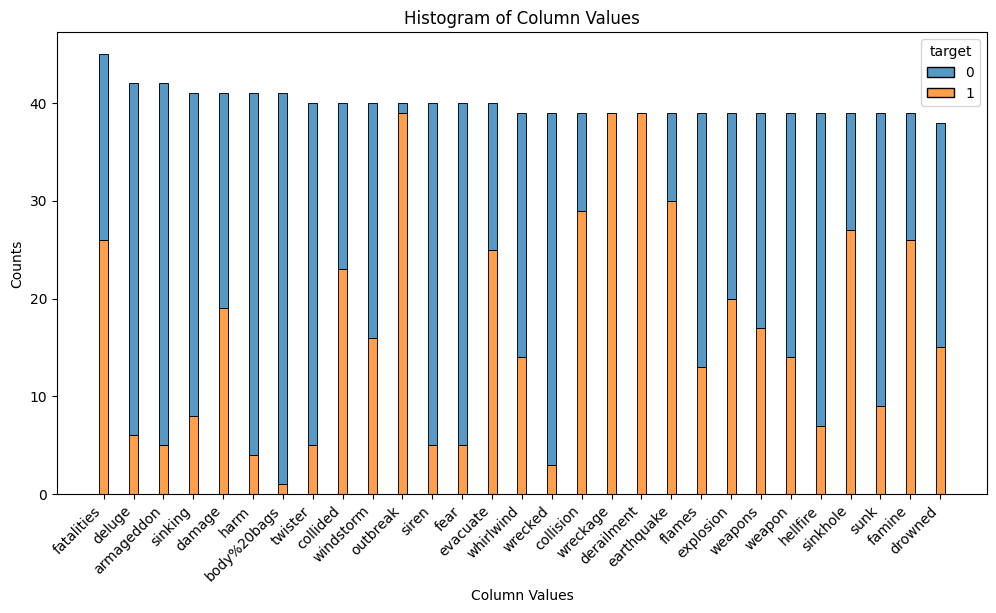

In [10]:
# 



df_train['keyword'] = df_train['keyword'].fillna('')
long_string = ' '.join(df_train['keyword'])

top_20 = df_train['keyword'].value_counts().sort_values(ascending=False)[1:30]
top_20_df = pd.DataFrame({'keyword': top_20.index})
df_merged = pd.merge(top_20_df, df_train, on='keyword', how='left')

plt.figure(figsize=(12, 6))
sns.histplot(data=df_merged, x='keyword', hue='target', multiple='stack', shrink=.3)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Column Values')
plt.ylabel('Counts')
plt.title('Histogram of Column Values')
plt.show()

<AxesSubplot:>

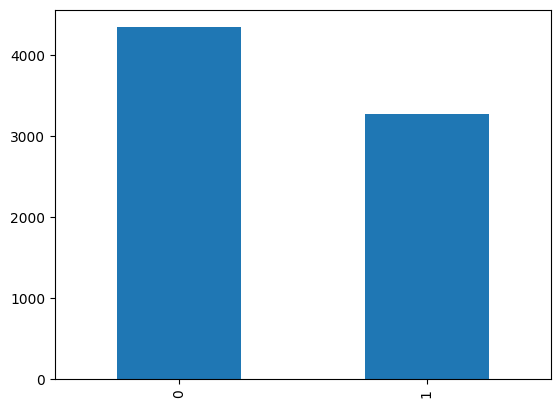

In [11]:
df_train['target'].value_counts().plot.bar()

Data pre-processing
- remove punctuation (no reason to believe it is important, and just adds to data dimensionality)
- tokenize text column (turn string into list of strings, words and entities like numbers appear as separate 'tokens')

In [13]:
# Remove Punctuation
punc_list = list(string.punctuation)
def remove_punctuation(text, punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text


# using lambda functions, create copies of the datasets and remove punctuation in the text columns.
df_train2 = df_train.copy()
df_train2['text'] = df_train2['text'].apply(lambda x: remove_punctuation(x, punc_list))
display(df_train2.head(5))
df_test2 = df_test.copy()
df_test2['text'] = df_test2['text'].apply(lambda x: remove_punctuation(x, punc_list))
display(df_test2.head(5))



,id,keyword,location,text,target
0,1,,NaN,Our Deeds are the Reason of this earthquake M...,1
1,4,,NaN,Forest fire near La Ronge Sask Canada,1
2,5,,NaN,All residents asked to shelter in place are ...,1
3,6,,NaN,13 000 people receive wildfires evacuation or...,1
4,7,,NaN,Just got sent this photo from Ruby Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities s...
2,3,NaN,NaN,there is a forest fire at spot pond geese are...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [16]:
token_df_train = df_train2.copy()
for column in df_train2.columns:
    token_df_train[column] = df_train2[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(token_df_train.head(5))


token_df_test = df_test.copy()
for column in df_test.columns:
    token_df_test[column] = df_test[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(token_df_test.head(5))

,id,keyword,location,text,target
0,1,[],NaN,"[Our, Deeds, are, the, Reason, of, this, earth...",1
1,4,[],NaN,"[Forest, fire, near, La, Ronge, Sask, Canada]",1
2,5,[],NaN,"[All, residents, asked, to, shelter, in, place...",1
3,6,[],NaN,"[13, 000, people, receive, wildfires, evacuati...",1
4,7,[],NaN,"[Just, got, sent, this, photo, from, Ruby, Ala...",1


,id,keyword,location,text
0,0,NaN,NaN,"[Just, happened, a, terrible, car, crash]"
1,2,NaN,NaN,"[Heard, about, #, earthquake, is, different, c..."
2,3,NaN,NaN,"[there, is, a, forest, fire, at, spot, pond, ,..."
3,9,NaN,NaN,"[Apocalypse, lighting, ., #, Spokane, #, wildf..."
4,11,NaN,NaN,"[Typhoon, Soudelor, kills, 28, in, China, and,..."


In [22]:
import gensim

# tokenize the text columns in 
s1 = token_df_train['text']
s2 = token_df_test['text']

sentence = pd.concat([s1, s2], axis=0)
len(sentence) # to see how many sentences we have in our ENTIRE data set (both training and testing)

10876

In [23]:
# take all tokens in the dataset, and the token 'forest' - convert the token to a vector, and identifies the similarity score of each token 
# (we only take 100 entries, otherwise the vector would be the size of the entire corpus)
w2v_model = gensim.models.Word2Vec(sentence,min_count=1,vector_size=100)
print(w2v_model.wv['forest'])

[-0.20492746  0.1193717   0.08377117  0.09400588  0.05226817 -0.3120991
  0.14338045  0.4891381  -0.12439024 -0.27230564  0.08969156 -0.28985378
  0.12582642  0.23910664  0.01768433 -0.13546857  0.11023869 -0.28112105
  0.1024432  -0.39318538  0.10825054  0.20047912  0.06885698 -0.27561346
  0.05745765  0.02451298 -0.13870667 -0.05417893 -0.17224696  0.11829447
  0.35517594 -0.09175165  0.01279092 -0.1543323  -0.19088785  0.3834391
  0.07045429 -0.20171379 -0.20271024 -0.24172306  0.06801689 -0.2406494
 -0.14899081 -0.02587644  0.24128322 -0.06304604 -0.31118777 -0.0854231
  0.06396486  0.03616398 -0.02825286 -0.12032565 -0.07011691  0.02818567
 -0.05818786  0.13792662  0.19183947  0.08938673 -0.11368899  0.0254775
  0.09652318  0.0699704   0.06646781 -0.01943167 -0.12919213  0.32413614
 -0.21004614 -0.00283258 -0.17055532  0.12473434 -0.01442886  0.18743208
  0.23861882  0.0560158   0.18400724 -0.130642    0.08615355 -0.11036923
 -0.05824084  0.08954148 -0.15439865  0.00120074 -0.1592

In [25]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df


# check the most similar words. This is a good check to see if the model is learning some latent relationships
most_similar(w2v_model,['our','title','client','company'])



,our,cos,title,cos,client,cos,company,cos
0,My,0.999756,Arrived,0.952724,Being,0.988364,30,0.997299
1,fire,0.999660,video,0.952131,TV,0.988014,No,0.997235
2,other,0.999649,07,0.950311,Flooding,0.987465,w,0.997145
3,their,0.999648,mosque,0.950149,occurred,0.987441,Great,0.997132
4,off,0.999602,Hawaii,0.950090,Mountain,0.987362,injury,0.997006
5,today,0.999564,Û,0.950083,cars,0.987301,hail,0.996997
6,family,0.999554,ViralSpell,0.949867,sound,0.987268,collide,0.996991
7,into,0.999553,reaÛ,0.949862,plant,0.987188,content,0.996948
8,damage,0.999509,gadgets,0.949635,Richmond,0.987179,for,0.996923
9,on,0.999482,Times,0.949472,11,0.987153,Some,0.996909


Model training

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_df_train['text'])

X_train = tokenizer.texts_to_sequences(token_df_train['text'])

In [29]:
token_df_train['text'][0][:10], X_train[0][:10]


(['Our',
  'Deeds',
  'are',
  'the',
  'Reason',
  'of',
  'this',
  'earthquake',
  'May',
  'ALLAH'],
 [118, 4581, 26, 4, 862, 8, 22, 261, 138, 1612])

In [30]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

t -> 1
co -> 2
http -> 3
the -> 4
a -> 5
in -> 6
to -> 7
of -> 8
i -> 9
and -> 10


In [31]:
import numpy as np
nos = np.array([len(x) for x in X_train])
len(nos[nos  < 700])

7613

In [38]:
#Lets keep all description to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all description of size maxlen defined above
X_train = pad_sequences(X_train, maxlen=maxlen)



#all description has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X_train[0])

# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [39]:
EMBEDDING_DIM = 100

# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
          weight_matrix[i] = model.wv[word]
    return weight_matrix



In [40]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [41]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


del embedding_vectors

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          2195100   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,312,477
Trainable params: 117,377
Non-trainable params: 2,195,100
_________________________________________________________________


In [43]:
# recall the data:
y_train = token_df_train['target']
token_df_train.head(5), y_train.head(5)

(   id keyword location                                               text  \
 0   1      []      NaN  [Our, Deeds, are, the, Reason, of, this, earth...   
 1   4      []      NaN      [Forest, fire, near, La, Ronge, Sask, Canada]   
 2   5      []      NaN  [All, residents, asked, to, shelter, in, place...   
 3   6      []      NaN  [13, 000, people, receive, wildfires, evacuati...   
 4   7      []      NaN  [Just, got, sent, this, photo, from, Ruby, Ala...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 0    1
 1    1
 2    1
 3    1
 4    1
 Name: target, dtype: int64)

In [44]:
X_test = tokenizer.texts_to_sequences(token_df_test['text'])
X_test = pad_sequences(X_test, maxlen=maxlen)
#y_test = merged_df['target']
print(type(X_test))
#print(type(y_test))
print(X_test[:5])
#print(y_test.head(5))


<class 'numpy.ndarray'>
[[   0    0    0 ... 1946  127   94]
 [   0    0    0 ...  609 2047  226]
 [   0    0    0 ...  353  102   42]
 [   0    0    0 ... 3902 7545 1493]
 [   0    0    0 ...  501   10 1193]]


In [45]:
print(type(X_train))
print(type(y_train))
print(X_train[:5])
print(y_train.head(5))
freq = y_train.value_counts()
print(freq)



<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
[[   0    0    0 ... 4582   88   42]
 [   0    0    0 ... 6853 6854 1208]
 [   0    0    0 ... 1396   26 1098]
 [   0    0    0 ... 1396    6   91]
 [   0    0    0 ...   72    5  188]]
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
0    4342
1    3271
Name: target, dtype: int64


Model training, with 6 epochs and a 30% validation split

In [46]:

model.fit(X_train, y_train, validation_split=0.3, epochs=6)



Epoch 1/6
167/167 [==============================] - 59s 342ms/step - loss: 0.6533 - acc: 0.6185 - val_loss: 0.5913 - val_acc: 0.6878
Epoch 2/6
167/167 [==============================] - 58s 345ms/step - loss: 0.6119 - acc: 0.6812 - val_loss: 0.5904 - val_acc: 0.6970
Epoch 3/6
167/167 [==============================] - 57s 339ms/step - loss: 0.5858 - acc: 0.7035 - val_loss: 0.5615 - val_acc: 0.7158
Epoch 4/6
167/167 [==============================] - 54s 325ms/step - loss: 0.5696 - acc: 0.7114 - val_loss: 0.5580 - val_acc: 0.7154
Epoch 5/6
167/167 [==============================] - 54s 325ms/step - loss: 0.5642 - acc: 0.7191 - val_loss: 0.5499 - val_acc: 0.7259
Epoch 6/6
167/167 [==============================] - 54s 324ms/step - loss: 0.5605 - acc: 0.7174 - val_loss: 0.5476 - val_acc: 0.7320


Checking accuracy score on training set...

In [47]:

y_pred = (model.predict(X_train) >= 0.5).astype("int")
accuracy_score(y_train, y_pred)


238/238 [==============================] - 23s 95ms/step


0.723893340338894

In [48]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.90      0.79      4342
           1       0.79      0.49      0.60      3271

    accuracy                           0.72      7613
   macro avg       0.74      0.69      0.70      7613
weighted avg       0.74      0.72      0.71      7613



Checking accuracy score on testing set...

In [ ]:
# for homework:
# create your own .csv file, with some labeled tweets. See how many of those it gets right.


# you will need to try loading in your own dataset as we see above, and then making predictions on it with the trained model.

my_dataset = ????
# pre-process data by tokenizing and vectorizing

# this should help you get started...
X_custom_test = ????

y_pred_result = (model.predict(X_custom_test) >= 0.5).astype("int")

y_custom_test = my_dataset['target']

accuracy_score(y_custom_test, y_pred_result)